In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
size = 256
channels = 1  #input image format
input_img = Input(shape=(size, size, channels))

def preprocess_image(image):
    #resize image so they're same format
    image = cv2.resize(image, (size, size))
    # Apply Gaussian Blurring to smooth the image and reduce noise
    image = cv2.GaussianBlur(image, (5, 5), 0)
    # Create a kernel for morphological operations
    kernel = np.ones((10, 10), np.uint8)
    # Apply morphological opening to the image
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    # Normalize the image to have values between 0 and 1
    image = np.expand_dims(image, axis=-1) / 255.0
    return image

def custom_preprocessor(img):
    # Assuming 'img' is a NumPy array of image data
    return preprocess_image(img)

datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessor,
    validation_split=0.15
)


In [3]:
#load trained model
autoencoder = load_model('goodmodel.keras')
#autoencoder = load_model('0504_5.keras')



In [4]:
anomalous_generator = datagen.flow_from_directory(
    'finalTestingAnomalousF',  #path to dataset
    target_size=(size, size),
    color_mode='grayscale',
    batch_size=32,
    class_mode='input',
    shuffle = False
)

Found 375 images belonging to 1 classes.


In [5]:
normal_generator = datagen.flow_from_directory(
    'finalTestingNormalF',  #path to dataset
    target_size=(size, size),
    color_mode='grayscale',
    batch_size=32,
    class_mode='input',
    shuffle = False
)

Found 93 images belonging to 1 classes.


In [10]:
#test model
predicted_anomalous = autoencoder.predict(anomalous_generator, steps=len(anomalous_generator))


/Users/yong/anaconda3/envs/plard/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step


In [11]:
predicted_normal = autoencoder.predict(normal_generator, steps=len(normal_generator))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


In [9]:
normal_generator.reset()
anomalous_generator.reset()

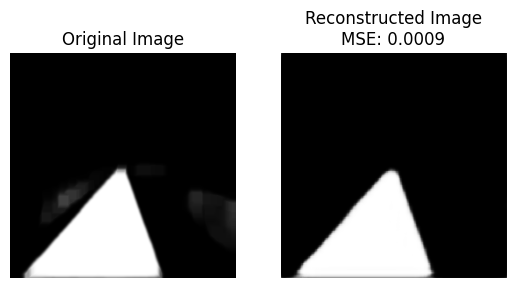

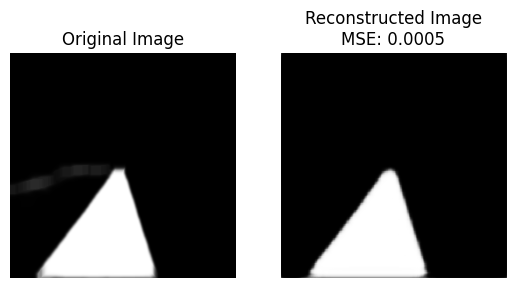

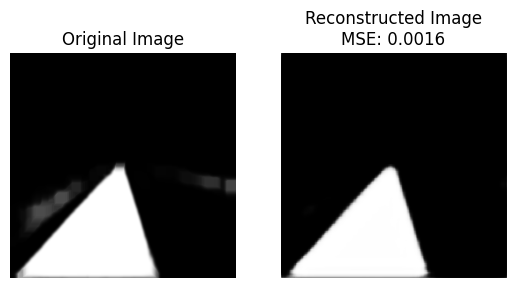

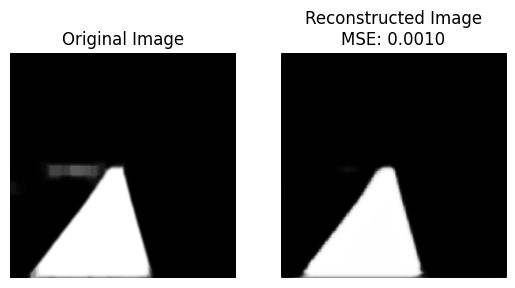

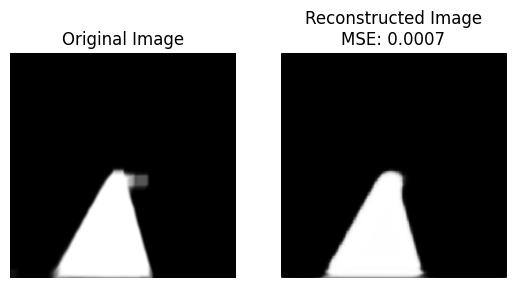

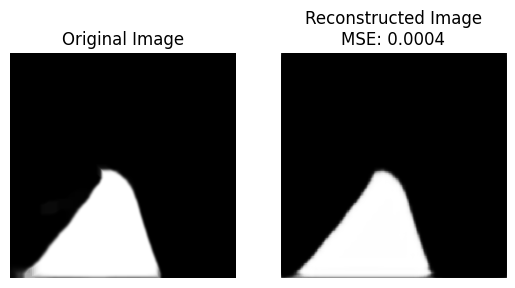

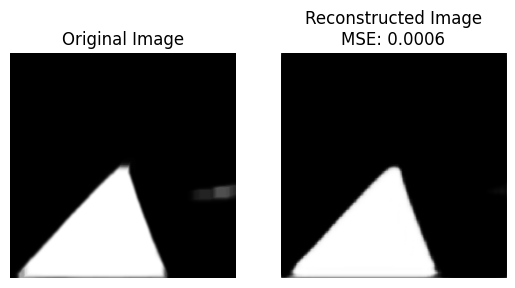

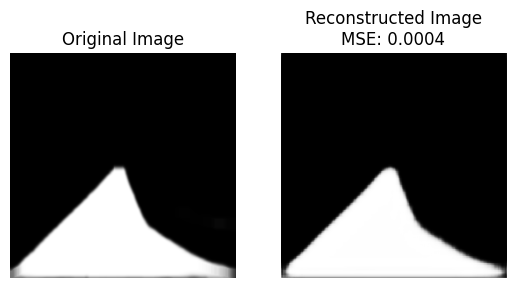

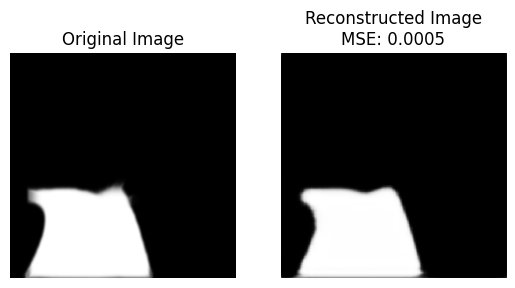

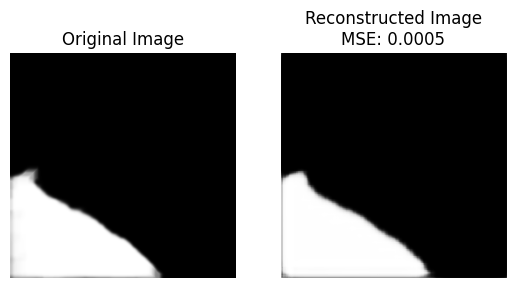

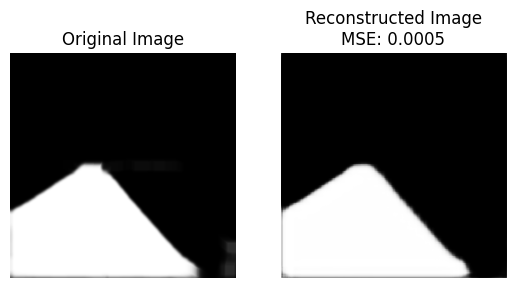

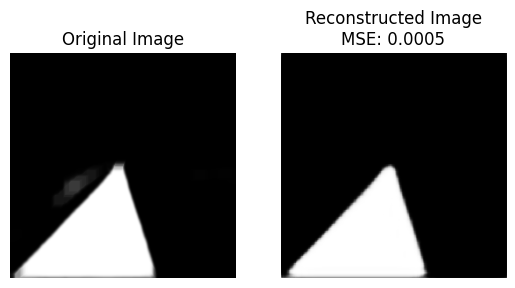

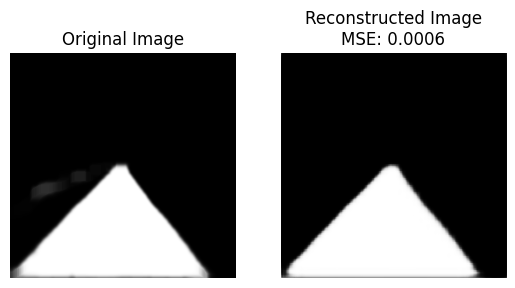

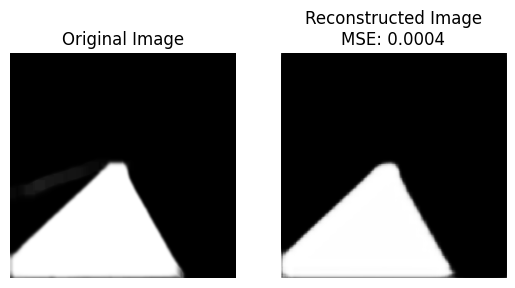

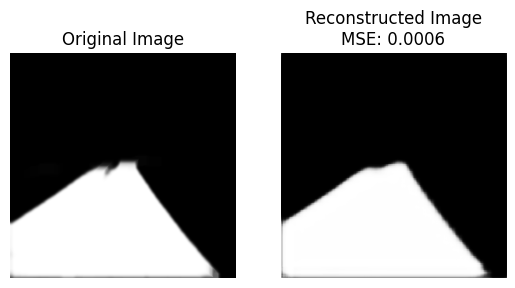

IndexError: index 96 is out of bounds for axis 0 with size 96

In [19]:
#function to calculate MSE
def mse_loss(original, reconstruction):
    return np.mean((original - reconstruction) ** 2)

#visualize first N images
N = 102

#reset generator
normal_generator.reset()

count = 0
for original_batch, _ in normal_generator:
    for j in range(original_batch.shape[0]):
        if count >= N:
            break

        original_img = original_batch[j]
        predicted_img = predicted_normal[count]

        #calculate the MSE loss
        loss = mse_loss(original_img, predicted_img)
        if loss > threshold:
            #plot original image
            plt.subplot(1, 2, 1)
            plt.imshow(original_img.squeeze(), cmap='gray')
            plt.title('Original Image')
            plt.axis('off')

            #plot predicted image
            plt.subplot(1, 2, 2)
            plt.imshow(predicted_img.squeeze(), cmap='gray')
            plt.title(f'Reconstructed Image\nMSE: {loss:.4f}')
            plt.axis('off')

            plt.show()

        count += 1
    if count >= N:
        break 

In [15]:
print(min(anomalous))

0.00023713717


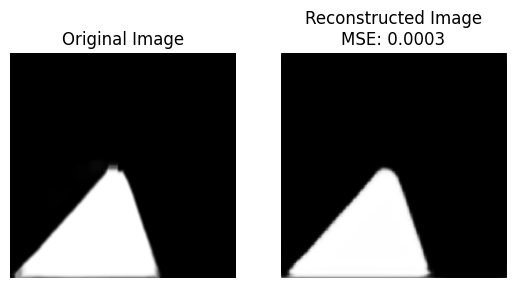

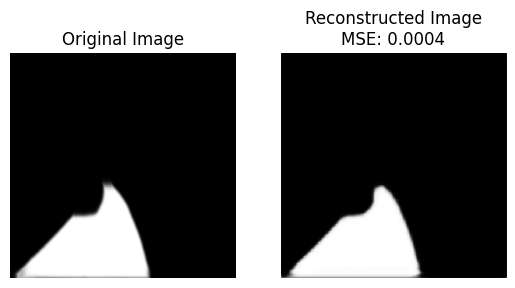

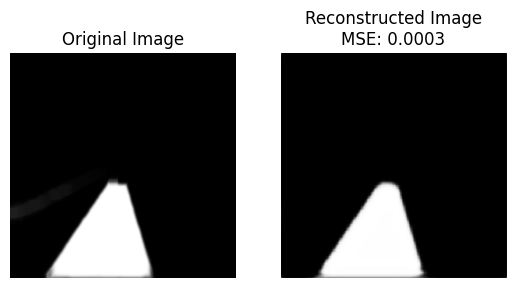

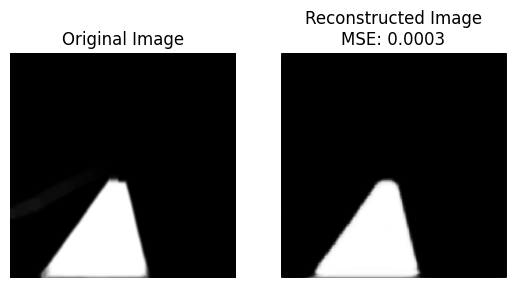

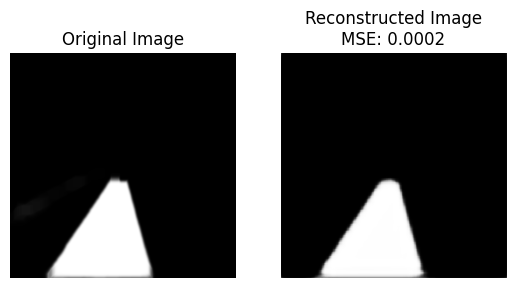

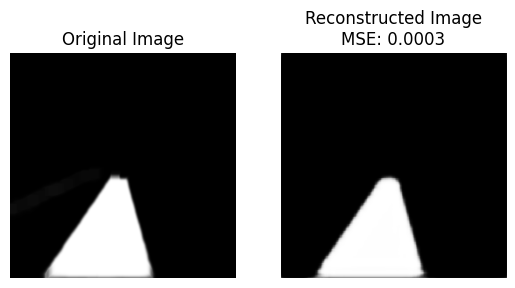

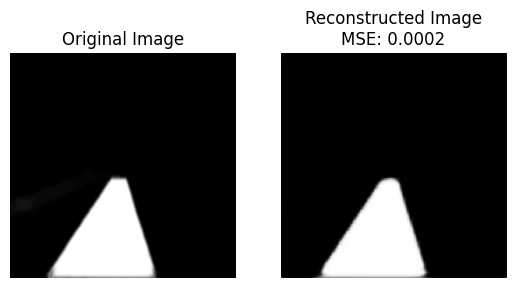

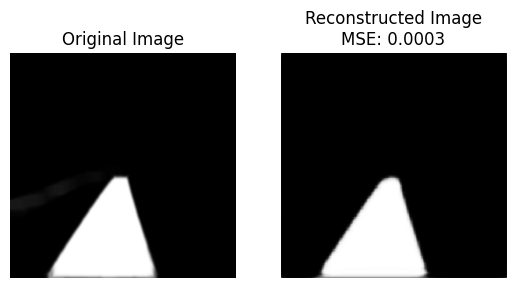

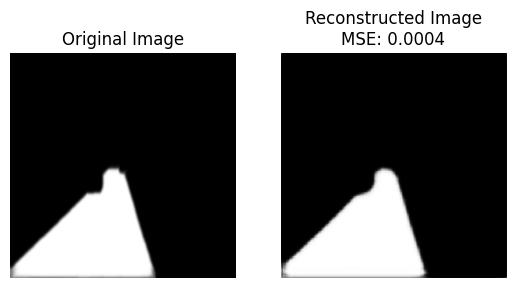

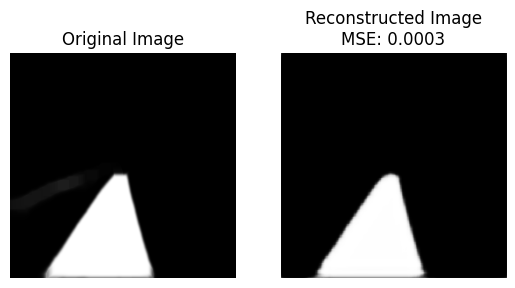

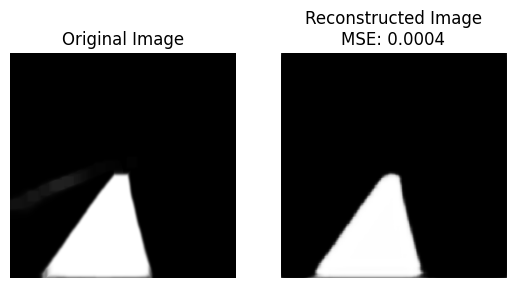

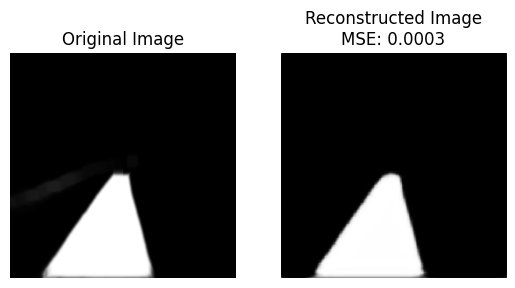

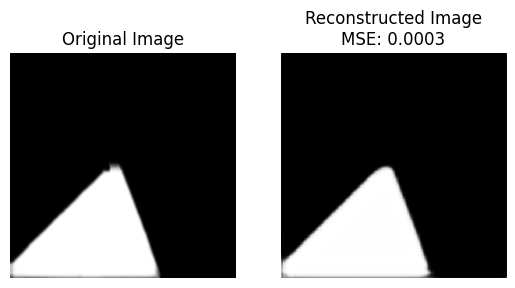

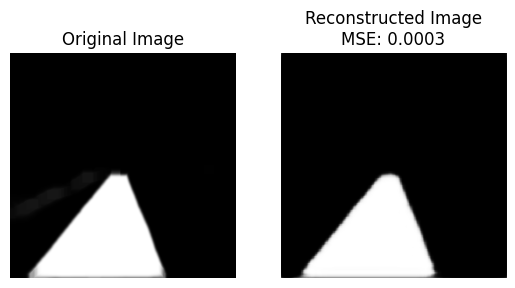

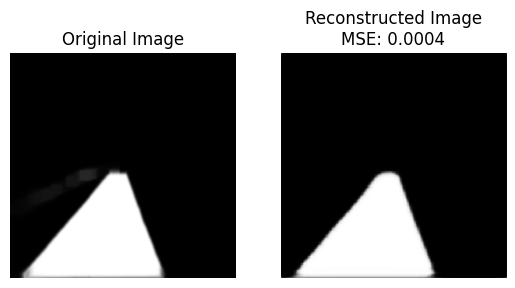

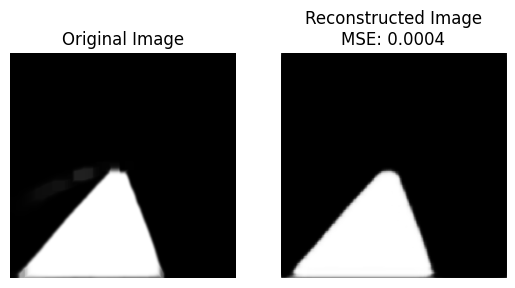

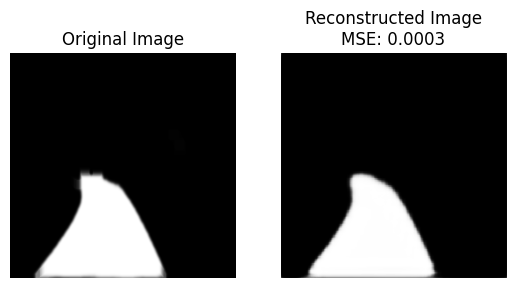

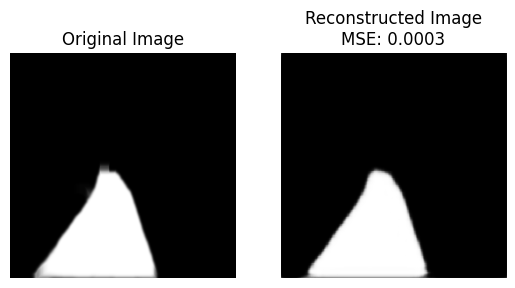

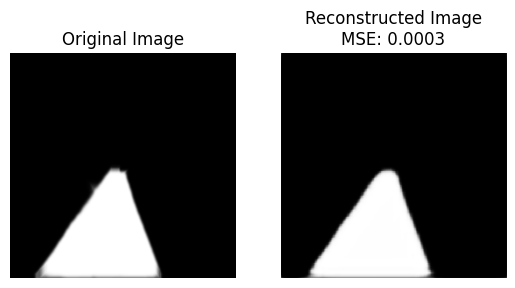

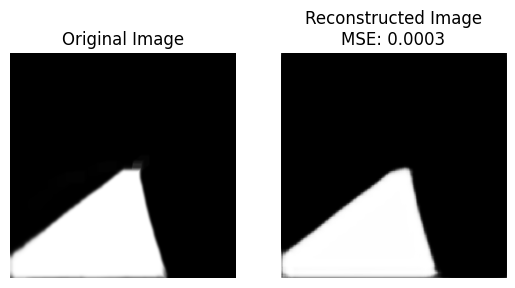

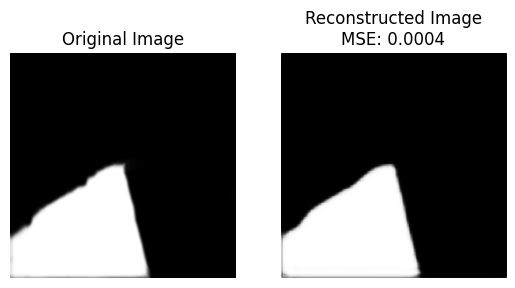

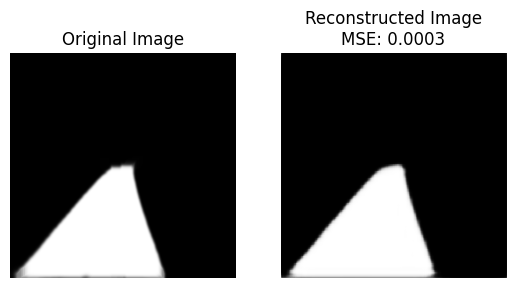

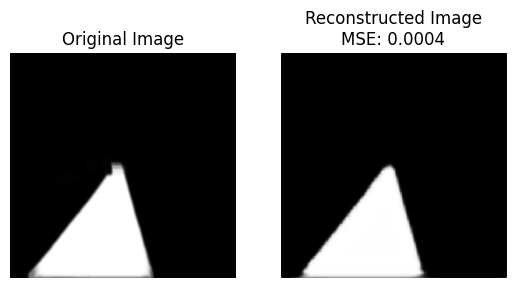

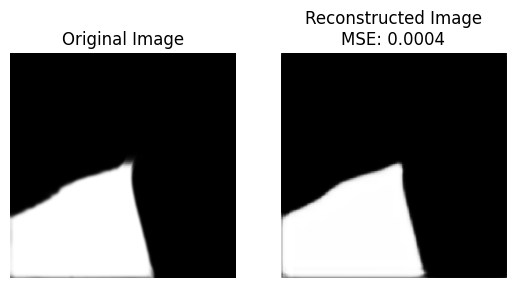

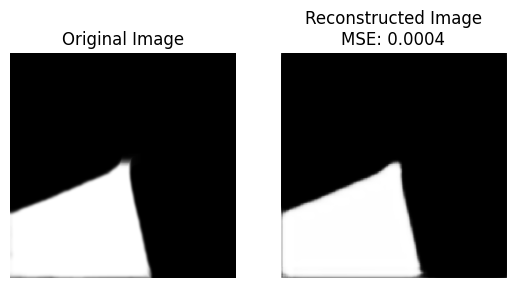

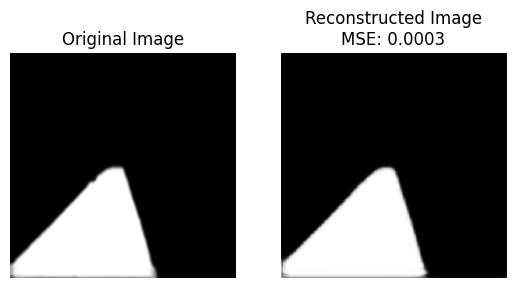

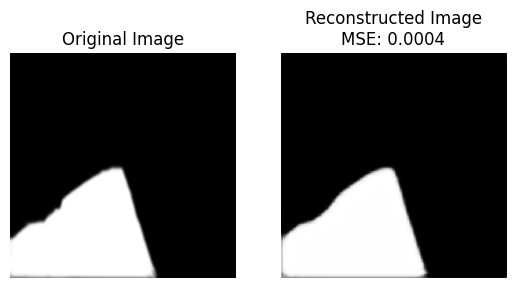

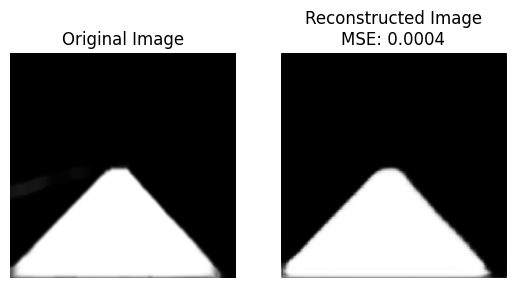

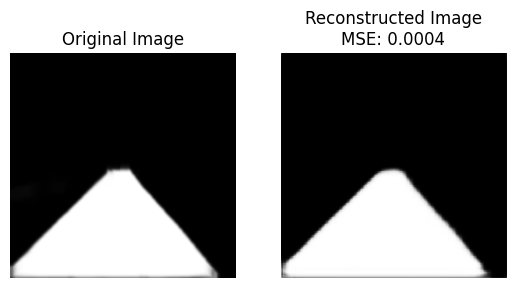

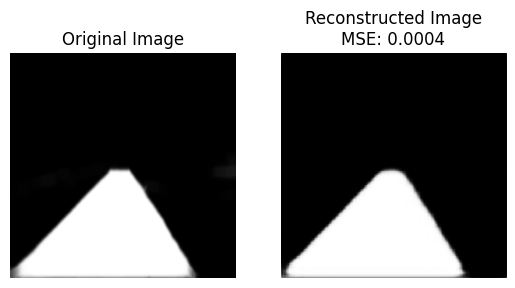

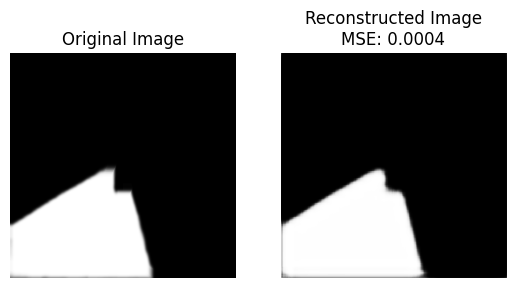

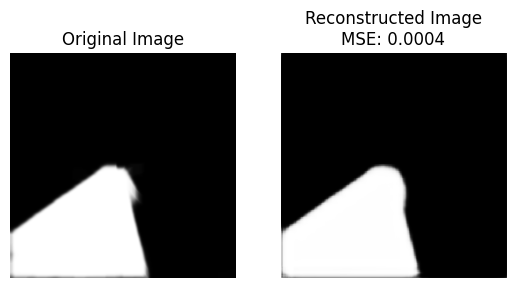

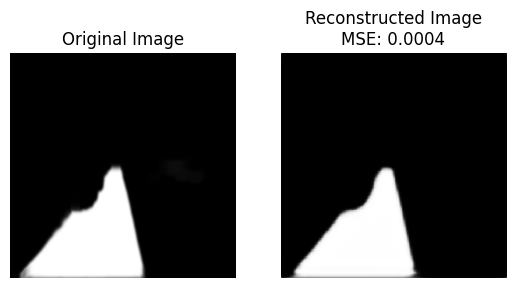

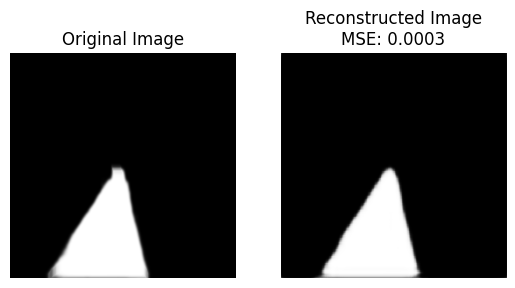

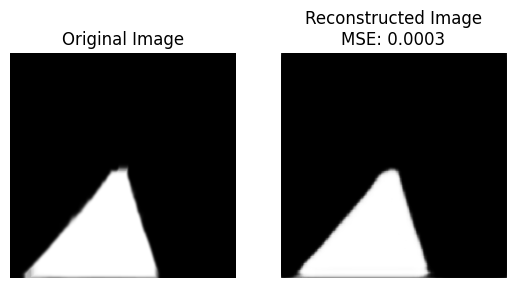

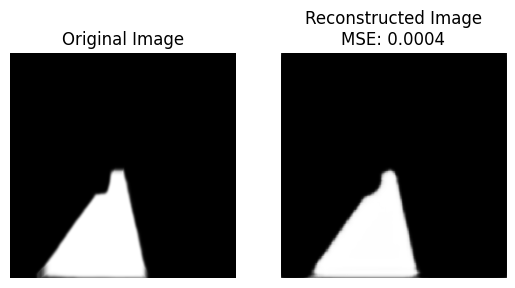

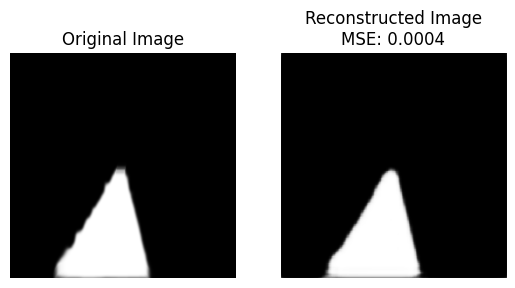

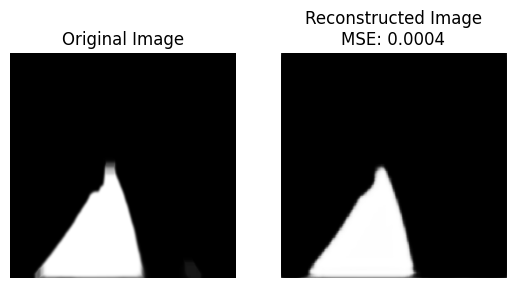

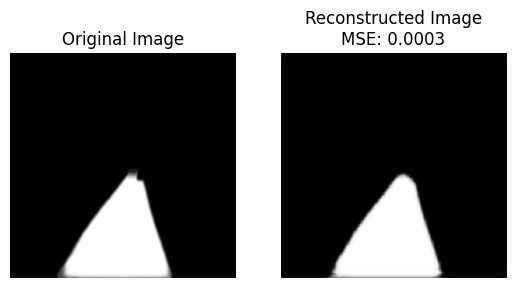

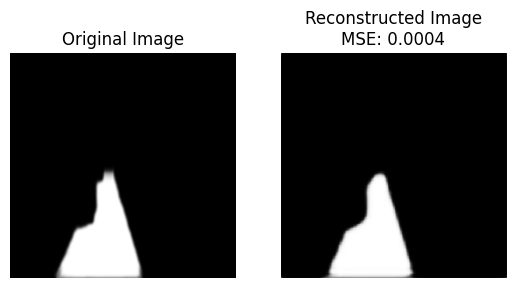

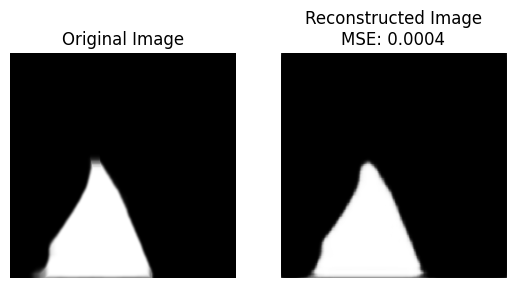

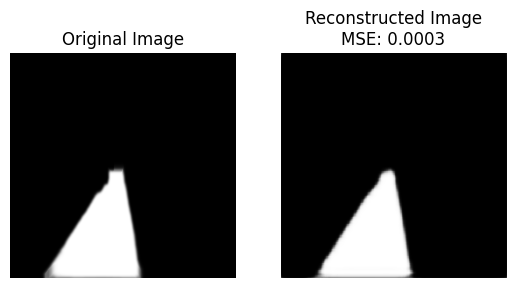

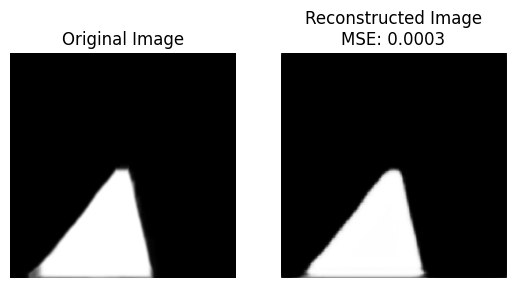

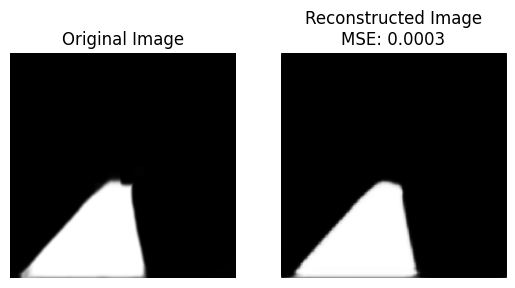

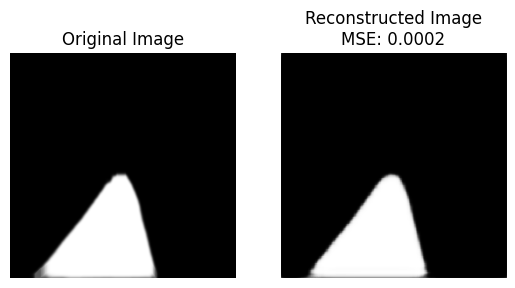

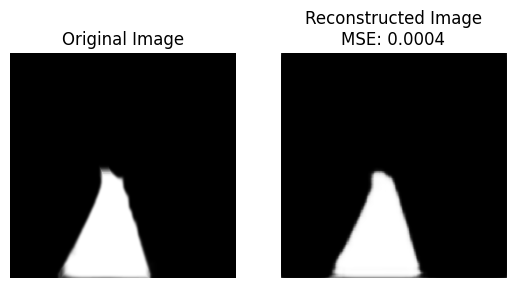

In [16]:
#function to calculate MSE
def mse_loss(original, reconstruction):
    return np.mean(np.square((original - reconstruction)))

#visualize first N images
N = 376

count = 0
for original_batch, _ in anomalous_generator:
    for j in range(original_batch.shape[0]):
        if count >= N:
            break

        original_img = original_batch[j]
        predicted_img = predicted_anomalous[count]

        #calculate the MSE loss
        loss = mse_loss(original_img, predicted_img)
        if loss <= threshold:
            #plot original image
            plt.subplot(1, 2, 1)
            plt.imshow(original_img.squeeze(), cmap='gray')
            plt.title('Original Image')
            plt.axis('off')

            #plot predicted image
            plt.subplot(1, 2, 2)
            plt.imshow(predicted_img.squeeze(), cmap='gray')
            plt.title(f'Reconstructed Image\nMSE: {loss:.4f}')
            plt.axis('off')

            plt.show()

        count += 1
    if count >= N:
        break 

In [6]:
#calculate MSE
def mse_loss(original, reconstruction):
    return np.mean(np.square(original - reconstruction))

def calculate_mse_values(model, generator):
    # Calculate the number of steps required to process all images
    num_samples = generator.samples
    batch_size = generator.batch_size
    steps = (num_samples + batch_size - 1) // batch_size  # Ensure all samples are covered
    print(f"Total samples: {num_samples}, Batch size: {batch_size}, Steps: {steps}")

    # Get predictions for the test images
    predicted_images = model.predict(generator, steps=steps)

    # Ensure the generator is properly reset for consistent image fetching
    generator.reset()

    # Initialize MSE values array
    mse_values = []
    count = 0

    # Process each batch
    for original_batch, _ in generator:
        for j in range(original_batch.shape[0]):
            # Check to prevent index out-of-bound error
            if count >= len(predicted_images):
                print(f"Stopping early: reached end of predicted images at count {count}")
                break

            original_img = original_batch[j]
            predicted_img = predicted_images[count]

            # Calculate MSE and store it
            loss = mse_loss(original_img, predicted_img)
            mse_values.append(loss)

            count += 1
        if count >= len(predicted_images):
                print(f"Stopping early: reached end of predicted images at count {count}")
                break

    print(f"Processed {count} images.")
    return mse_values


Total samples: 375, Batch size: 32, Steps: 12


/Users/yong/anaconda3/envs/plard/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step
Stopping early: reached end of predicted images at count 375
Processed 375 images.


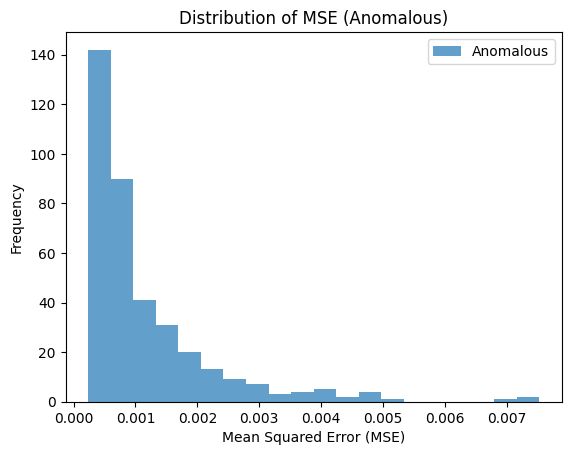

In [9]:
#anomalous MSE distribution plot 
anomalous = calculate_mse_values(autoencoder, anomalous_generator)
plt.hist(anomalous, bins=20, alpha=0.7, label='Anomalous')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of MSE (Anomalous)')
plt.legend()

plt.show()

Total samples: 93, Batch size: 32, Steps: 3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Stopping early: reached end of predicted images at count 93
Processed 93 images.


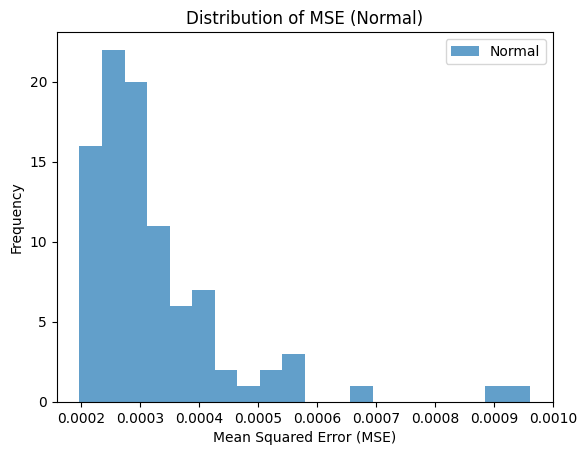

In [10]:
#normal MSE distribution plot 
normal = calculate_mse_values(autoencoder, normal_generator)
plt.hist(normal, bins=20, alpha=0.7, label='Normal')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of MSE (Normal)')
plt.legend()

plt.show()

In [13]:
threshold = 3.5723e-04

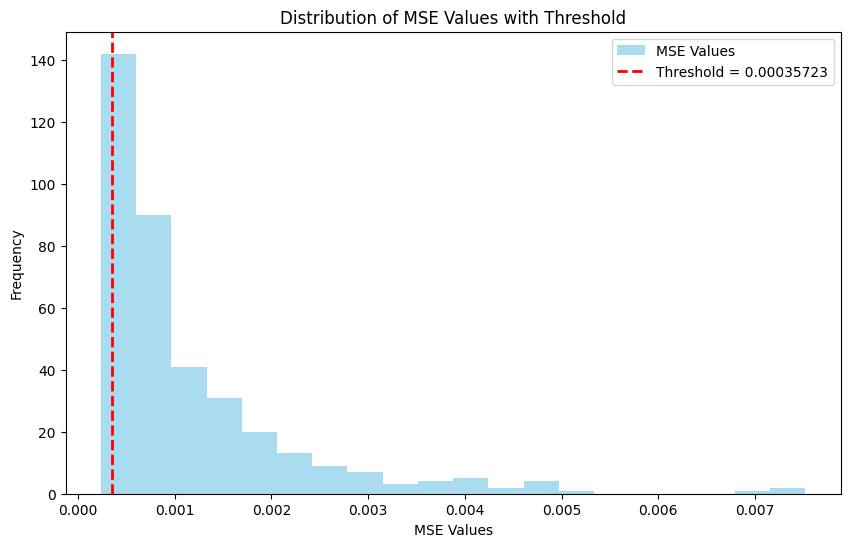

375
352
Percentage of MSE values above the threshold: 93.87%


In [15]:
def analyze_mse_anomalous(mse_values, threshold):
    """
    Analyzes and plots the MSE values to show how many are on or below a given threshold.
    
    Args:
    mse_values (list or array): The MSE values.
    threshold (float): The threshold value for comparison.
    
    Returns:
    float: The percentage of MSE values on or below the threshold.
    """
    # Calculate the number of MSE values on or below the threshold
    above_threshold = [mse for mse in mse_values if mse > threshold]
    percentage_below = (len(above_threshold) / len(mse_values)) * 100
    
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.hist(mse_values, bins=20, color='skyblue', alpha=0.7, label='MSE Values')
    plt.axvline(x=threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold = {threshold}')
    plt.xlabel('MSE Values')
    plt.ylabel('Frequency')
    plt.title('Distribution of MSE Values with Threshold')
    plt.legend()
    plt.show()
    print(len(mse_values))
    print(len(above_threshold))
    return percentage_below

percentage = analyze_mse_anomalous(anomalous, threshold)
print(f"Percentage of MSE values above the threshold: {percentage:.2f}%")


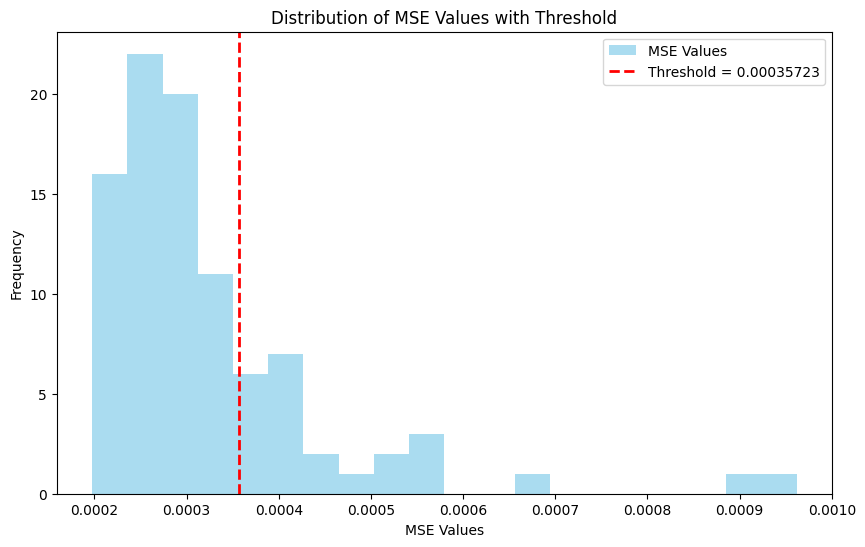

93
70
Percentage of MSE values on or below the threshold: 75.27%


In [14]:
def analyze_mse_normal(mse_values, threshold):
    """
    Analyzes and plots the MSE values to show how many are on or below a given threshold.
    
    Args:
    mse_values (list or array): The MSE values.
    threshold (float): The threshold value for comparison.
    
    Returns:
    float: The percentage of MSE values on or below the threshold.
    """
    # Calculate the number of MSE values on or below the threshold
    below_threshold = [mse for mse in mse_values if mse <= threshold]
    percentage_below = (len(below_threshold) / len(mse_values)) * 100
    
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.hist(mse_values, bins=20, color='skyblue', alpha=0.7, label='MSE Values')
    plt.axvline(x=threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold = {threshold}')
    plt.xlabel('MSE Values')
    plt.ylabel('Frequency')
    plt.title('Distribution of MSE Values with Threshold')
    plt.legend()
    plt.show()
    print(len(mse_values))
    print(len(below_threshold))
    return percentage_below

percentage = analyze_mse_normal(normal, threshold)
print(f"Percentage of MSE values on or below the threshold: {percentage:.2f}%")


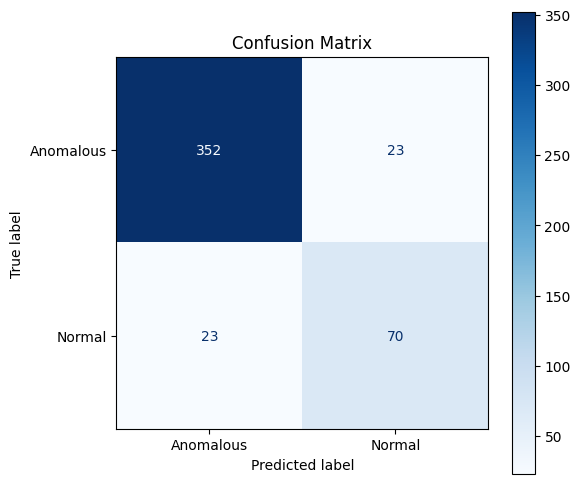

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Example data: true_labels and predicted_labels need to be filled with your actual data
true_labels = [1 if i < 375 else 0 for i in range(375+93)]  # 264 benign (259 TP + 5 FN), 33 malignant (22 TN + 11 FP)
predicted_labels = [1]*352 + [0]*23 + [0]*70 + [1]*23  # Predicted labels according to your confusion matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[1, 0])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=['Anomalous', 'Normal'])
disp.plot(cmap=plt.cm.Blues, ax=ax)
disp.ax_.set_title('Confusion Matrix')
plt.show()

